In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

In [ ]:
!pip install wandb piq

In [3]:
import wandb
from piq import SSIMLoss, FID
from piq.feature_extractors import InceptionV3

In [4]:
# Set random seed for reproducibility
seed = 777
random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

In [ ]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d soumikrakshit/anime-faces
!mkdir anime
!unzip anime-faces.zip -d anime
!rm anime-faces.zip

**Source:** https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [8]:
wandb.login()

wandb: Currently logged in as: alexis852 (alexis852-team). Use `wandb login --relogin` to force relogin


True

In [9]:
dataroot = "anime/data" # Root directory for dataset
workers = 2             # Number of workers for dataloader
batch_size = 128        # Batch size during training
eval_batch_size = 100   # Batch size during evaluation
image_size = 64         # All images will be resized to this size using a transformer
nc = 3                  # Number of channels in the training images. For color images this is 3
nz = 100                # Size of z latent vector (i.e. size of generator input)
ngf = 64                # Size of feature maps in generator
ndf = 64                # Size of feature maps in discriminator
num_epochs = 5          # Number of training epochs
lr = 0.0002             # Learning rate for optimizers
beta1 = 0.5             # Beta1 hyperparameter for Adam optimizers

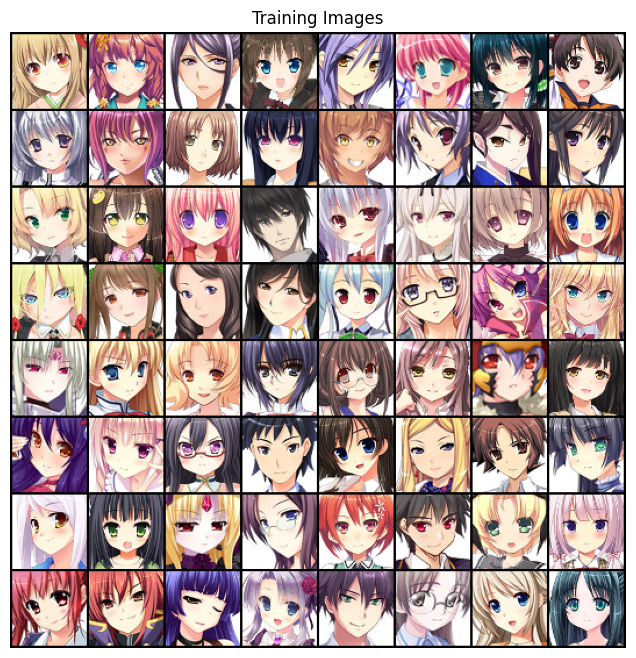

In [10]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers,
                                         drop_last=True) # 21551 % 128 == 47

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

In [11]:
def collate_fn(data):
    batch = []
    for item in data:
        batch.append(item[0].unsqueeze(0))
    return {'images': torch.cat(batch, dim=0)}


val_dataloader = torch.utils.data.DataLoader(dataset, batch_size=eval_batch_size,
                                             shuffle=True, num_workers=workers)
val_images = next(iter(val_dataloader))
val_dataset = torch.utils.data.TensorDataset(val_images[0])
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=eval_batch_size,
                                             collate_fn=collate_fn)

In [12]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [13]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace=True),
            # (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(inplace=True),
            # (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True),
            # (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True),
            # ngf x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # nc x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [14]:
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [15]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [16]:
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [17]:
def goofy_ahh_shift(data):
    return (data + 1) / 2

In [24]:
def evaluate_fid(real_dl, fake_dl):
    fid_metric = FID()
    first_feats = fid_metric.compute_feats(real_dl, device=device, feature_extractor=InceptionV3(normalize_input=False))
    second_feats = fid_metric.compute_feats(fake_dl, device=device, feature_extractor=InceptionV3(normalize_input=False))
    fid = fid_metric(first_feats, second_feats)
    return fid


def evaluate_ssim(real_dl, fake_dl):
    ssim_loss = SSIMLoss()
    real_imgs = next(iter(real_dl))['images'].to(device)
    fake_imgs = next(iter(fake_dl))['images'].to(device)
    ssim = ssim_loss(goofy_ahh_shift(real_imgs),
                     goofy_ahh_shift(fake_imgs))
    return ssim

In [25]:
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(eval_batch_size, nz, 1, 1, device=device)

real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
wandb.init(
    project="bhw-gans",
    config={
        "batch_size": batch_size,
        "learning_rate": lr,
        "nz": nz,
        "ngf": ngf,
        "nsf": ndf,
        "epochs": num_epochs,
    }
)

**Hacks:**
* We will ''construct different mini-batches for real and fake'' images;
* Adjust G's objective function to maximize $\log(D(G(z)))$.

What to track during training:
* Loss
* FID
* SSIM
* Model evolution

In [32]:
def train_gan(num_epochs, start_iter=0):
    # Lists to keep track of progress
    img_list = []
    G_losses = []
    D_losses = []
    fids = []
    ssims = []
    iters = start_iter

    for epoch in range(num_epochs):
        for i, data in enumerate(dataloader, 0):
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device) # 0.9?
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(fake_label) # 0.1?
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, num_epochs, i, len(dataloader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
                wandb.log({"epoch": epoch,
                           "Loss_D": errD.item(),
                           "Loss_G": errG.item(),
                           "D(x)": D_x,
                           "D(G(z)) before step": D_G_z1,
                           "D(G(z)) after step": D_G_z2}, step=iters)

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach()
                    # Computing FID and SSIM
                    gen_dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(fake),
                                                                 batch_size=eval_batch_size, collate_fn=collate_fn)
                    fid = evaluate_fid(val_dataloader, gen_dataloader)
                    ssim = evaluate_ssim(val_dataloader, gen_dataloader)
                wandb.log({"FID": fid, "SSIM": ssim}, step=iters)
                fids.append(fid)
                ssims.append(ssim)
                images = vutils.make_grid(fake[:64,:,:,:], padding=2, normalize=True)
                img_list.append(images)
                images = wandb.Image(images, caption=f"G(z) at iteration {iters}")
                wandb.log({"Fake images": images})

            iters += 1

    return img_list, G_losses, D_losses, fids, ssims

In [ ]:
train_gan(num_epochs=5)

In [ ]:
train_gan(num_epochs=10, start_iter=840)

In [ ]:
train_gan(num_epochs=20, start_iter=2520)

In [34]:
torch.save(netG, "Generator")

In [35]:
torch.save(netD, "Discriminator")